# Lesson 1
### This is my personal notebook of Fast.ai Lesson 1
The course's original Notebook can be found [here](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)

## **Introduction**

**Neural networks** come in different shapes and sizes, and depending on how they are structured, their results tend to vary. Fortunately, you do not have to reinvent the wheel for every solution you wish to build. There are a number of architectures out there that have proven to be extremely successful, so we can reuse those for our own classifier. Using the fast.ai libary, we can indicate which architecture we want to use to train our network on, instead of having to build it all by ourselves.</p>

Here we use “resnet34”, which has some “related” architectures some of which are also implemented in fast.ai, you can play around and see what results you are able to get:

* resnet18
* resnet50
* resnet101
* resnet152




<p>Other architectures for image classification include:</p>

* GoogleNet
* AlexNet
* VGG
* Inception v(1, 2, 3)

## Adding the necessites (Data and Dependencies )

These extra steps are required for using this notebook on Google Colab.
For more, [click here](https://forums.fast.ai/t/fast-ai-with-google-colab/18882)

Check how much RAM you have been allocated.
It should be 11GB ideally.
If it's not, you might want to read [this](https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available)

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

In [0]:
#%reload_ext autoreload
#%autoreload 2
%matplotlib inline

In [0]:

# Install fastai
!pip3 install fastai==0.7.0

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
!{sys.executable} -m pip install torchtext==0.2.3

In [0]:
!pip install pillow==4.0.0

To get the data

In [0]:
# Get the Dogs & Cats data, unzip it, and put it in the 'data' directory:
!wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/

In [17]:
# Check to make sure the folders all unzipped properly:
!ls data/dogscats

models	sample	test1  train  valid


Import fastai

In [0]:
from fastai.imports import *

In [0]:

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [18]:
torch.cuda.is_available()#this should return true

True

In [19]:
torch.backends.cudnn.enabled#this should return true.

True

##Checking out the data

PATH is the path to your data

---


 sz is the size that the images will be resized to in order to ensure that the training runs quickly.

---

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA.

---

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. 

The data is classified already into the folders i.e. we have a 'cats' folder containing all the images labelled as cats and 'dogs' for dogs.

In [0]:
PATH = "data/dogscats/"
sz=224

Our library will assume that you have train and valid directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [22]:
os.listdir(PATH)

['test1', 'models', 'valid', 'sample', 'train']

In [23]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [24]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11191.jpg',
 'cat.7073.jpg',
 'cat.1812.jpg',
 'cat.10786.jpg',
 'cat.8567.jpg']

Now 'img' is a 3D array.</p>
It has three layers of number between 0 to 255 each corresponding to a different intensity of Red, Green and Blue</p>


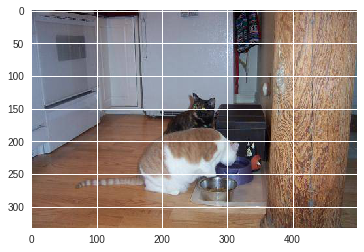

In [25]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

## Using pre-trained model

We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

---


We create a learner object to train our network on the data using the architecture we selected above. An additional benefit to using a pre-existing network archicture, is that it usually comes with a pretrained model, meaning the architecture has already been pretrained a massive dataset (e.g. ImageNet). This way we do not start training from zero (or some random initialization) but we start from a model that already gives good results, and adapt it to fit our specific needs. This is method of learning is called Transfer Learning.

---

**tfms**</p>
tfms stands for transformations. **tfms_from_model** takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

---

**PATH**</p>
We need a path that points to the dataset. In this path we will also store temporary data and final results. **ImageClassifierData.from_paths** reads data from a provided path and creates a dataset ready for training.

---



**ConvLearner.pretrained** builds learner that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pre-trained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.


![](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)


Parameters are learned by fitting a model to the data. Hyperparameters are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the learning rate and the number of epochs.

During iterative training of a neural network, a batch or mini-batch is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An epoch is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now fit the model; that is, use gradient descent to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperparameters: the learning rate (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the number of epochs (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [26]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 89164876.17it/s]


100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.049046   0.025099   0.9915    
    1      0.043612   0.024701   0.991     



[array([0.0247]), 0.991]

## Learning Rate Finder

The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [0]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [30]:
lrf=learn.lr_find()
lrf

 84%|████████▍ | 303/360 [00:07<00:01, 47.84it/s, loss=0.433]


Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

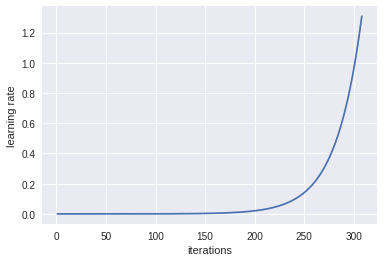

In [31]:
learn.sched.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/batch_size) iterations of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

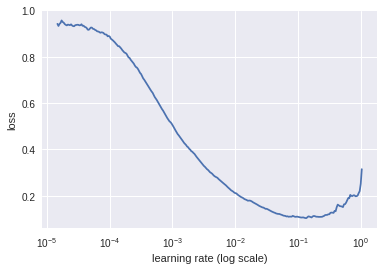

In [32]:
learn.sched.plot()


The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

## Data Augmentation


If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.

In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]


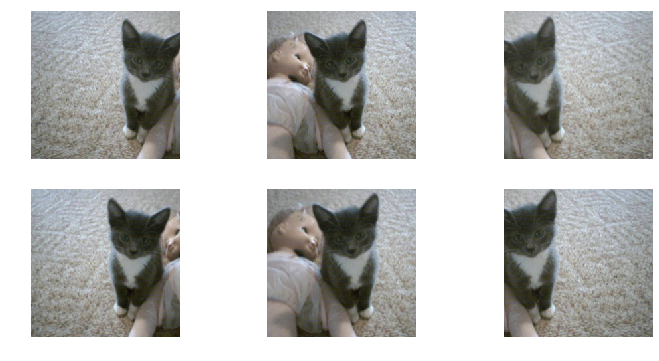

In [35]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

Let's create a new data object that includes this augmentation in the transforms.

In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [37]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.044939   0.031669   0.989     



[array([0.03167]), 0.989]

In [0]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to frozen. That means that it's still only updating the weights in the last layer when we call fit.

In [0]:
learn.fit(1e-2, 3, cycle_len=1)


epoch      trn_loss   val_loss   accuracy   
    0      0.042907   0.028761   0.989     
    1      0.042518   0.025153   0.99      
    2      0.04805    0.023526   0.9905    



[array([0.02353]), 0.9905]

What is that cycle_len parameter? What we've done here is used a technique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". To know more, [click here](https://arxiv.org/pdf/1704.00109.pdf)



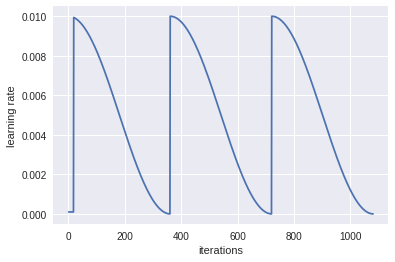

In [0]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

## Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().

In [0]:
learn.unfreeze()

Note that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [42]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.046896   0.027866   0.9895    
    1      0.047775   0.026901   0.99      
    2      0.04751    0.026193   0.99      
    3      0.039595   0.027591   0.989     
    4      0.03523    0.028149   0.988     
    5      0.037082   0.026844   0.9895    
    6      0.041193   0.027215   0.9885    



[array([0.02721]), 0.9885]

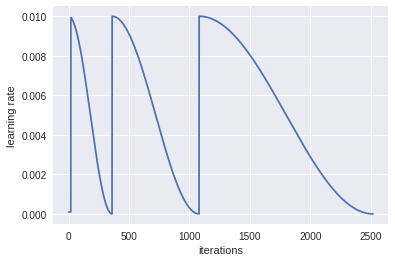

In [43]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the final layers. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set lr=np.array([1e-4,1e-3,1e-2]).

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at inference time (also known as test time). Not surprisingly, this is known as test time augmentation, or just TTA.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's TTA() method.

In [46]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
#fastai and PyTorch return results as log of the predictions so we take exponent of the results

In [47]:
accuracy_np(probs, y)

0.99

## Analyzing Results

When we run learn.fit we print 3 performance values (see above.) Here 0.03 is the value of the **loss in the training set**, 0.0226 is the value of the **loss in the validation set** and 0.9927 is the **validation accuracy**. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the loss function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by: **-(y * log(p) + (1-y) * log (1-p))** where y is the true label of x and p is the probability predicted by our model that the label is 1.

In [0]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[991   9]
 [ 11 989]]


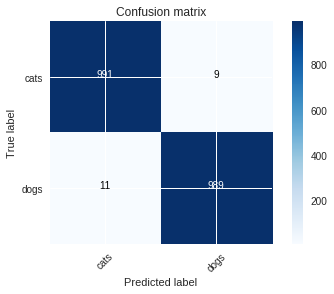

In [50]:
plot_confusion_matrix(cm, data.classes)

## Review

###General Steps
1.  precompute=True
2.  Use lr_find() to find highest learning rate where loss is still clearly improving
3.  Train last layer from precomputed activations for 1-2 epochs
4.  Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5.  Unfreeze all layers
6.  Set earlier layers to 3x-10x lower learning rate than next higher layer
7.  Use lr_find() again
8.  Train full network with cycle_mult=2 until over-fitting

